In [49]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

# Random Forest

## Load data

In [50]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

1760

In [51]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'groundwater depth', 'elevation', 'lon', 'lat',
       'precipitation', 'temperature', 'n deposition',
       'mainsoilclassification_1', 'organicmattercontent_1', 'density_1',
       'acidity_1'],
      dtype='object')

In [52]:
# df = df[~df["soil region"].isin(["veen", "zand"])]
# len(df)

## Sort by date

In [53]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
len(df)

1760

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [54]:
df = df.drop(columns=['soil region'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

952

## Add month and year as a feature

In [55]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [56]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

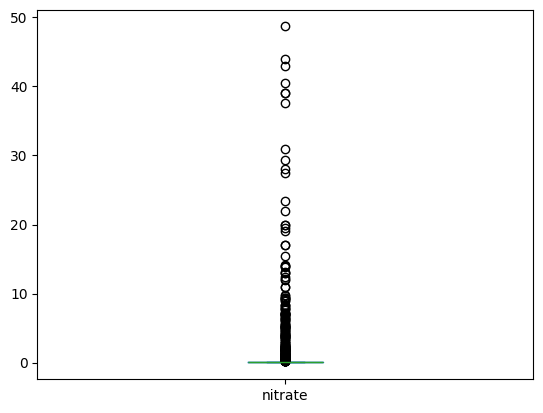

In [57]:
df[["nitrate"]].plot(kind = "box")

In [58]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
# outliers

Outliers found: 211


In [59]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-5:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

947

## Test / train split

In [60]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 770
Test: 177


In [61]:
# n = len(df)
# train_size = int(n * 0.8)

# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# print(f"Train: {len(train_df)}")
# print(f"Test: {len(test_df)}")


In [62]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [63]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [64]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['landuse code', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [65]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [66]:
rf_model = RandomForestRegressor(random_state=42, oob_score=False)

In [67]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("rf", rf_model)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [68]:
param_grid = {
    "regressor__rf__n_estimators": [50, 100, 150, 200],
    "regressor__rf__max_features": ["sqrt", 0.5, 1],
    "regressor__rf__max_depth": [None, 5, 10, 15],
    "regressor__rf__min_samples_split": [2, 4, 6],
    "regressor__rf__min_samples_leaf": [1, 2, 3]
}

## Hyperparameter tuning

In [69]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=9,
    verbose=1
)
search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [70]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.6206153212161047
Best params: {'regressor__rf__n_estimators': 200, 'regressor__rf__min_samples_split': 2, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__max_features': 0.5, 'regressor__rf__max_depth': 15}


## Learning curve

In [71]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [72]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

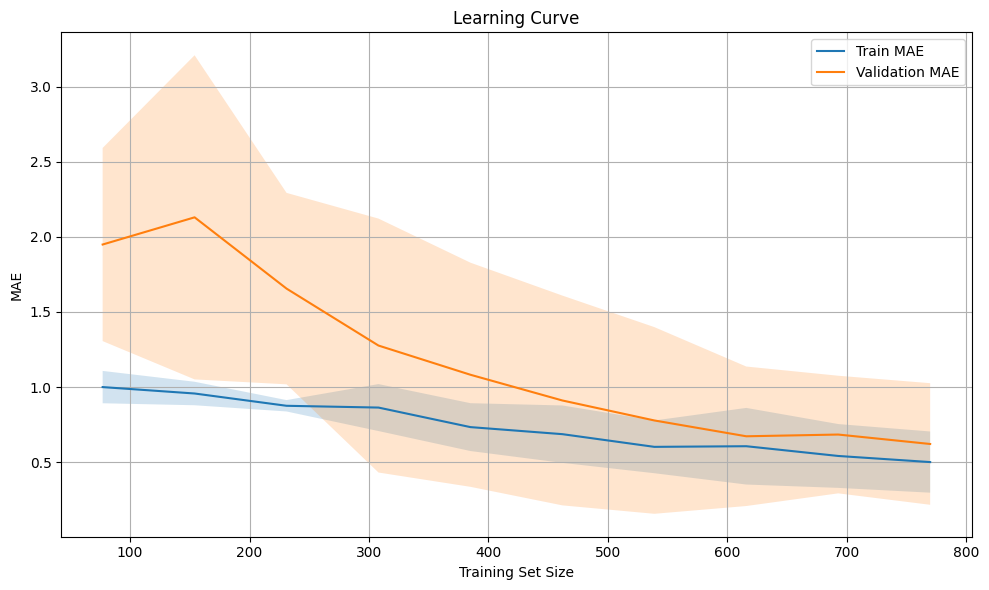

In [73]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

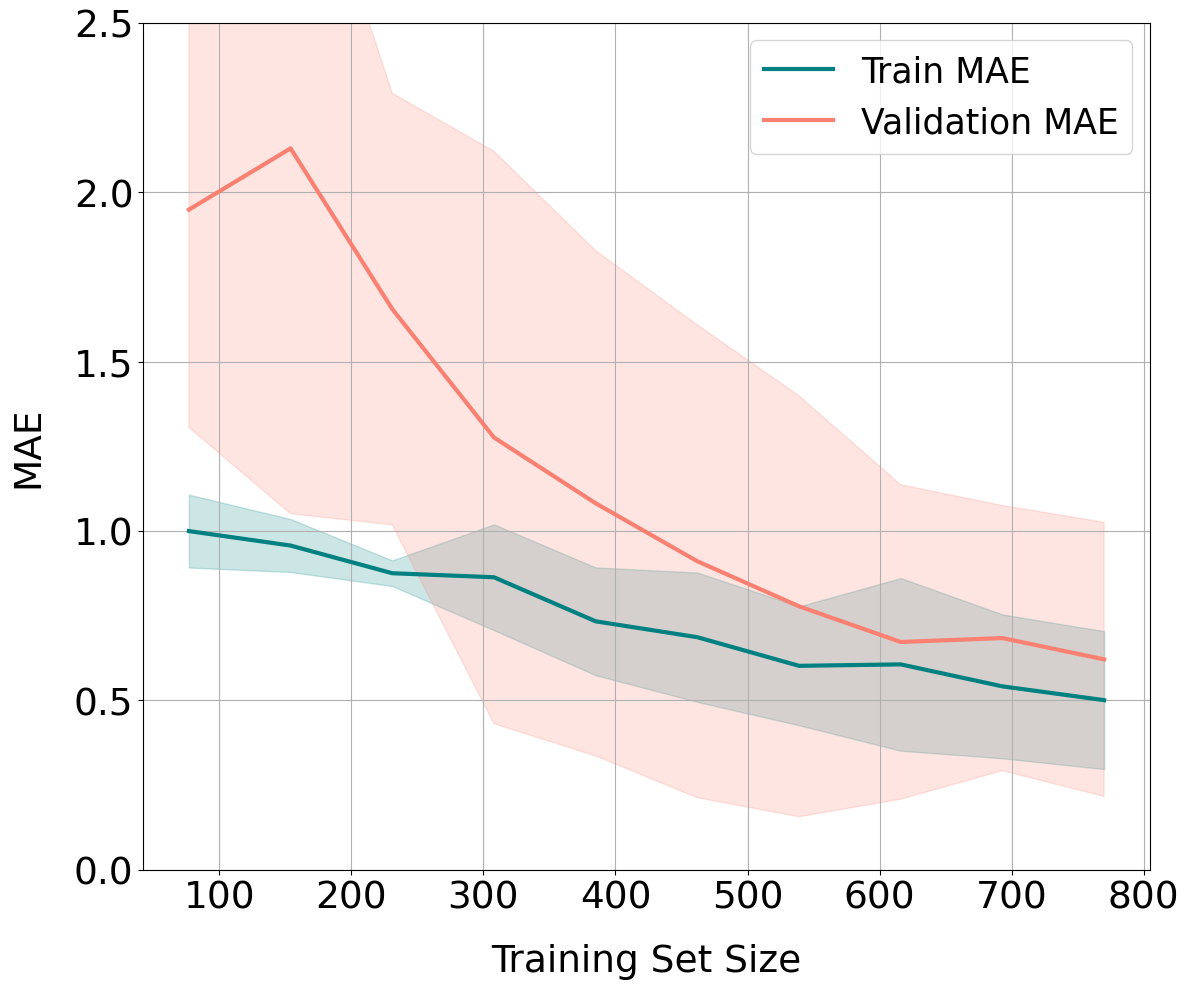

In [74]:
import matplotlib.pyplot as plt

train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

# Plot lines with custom colors
plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

# Increase font sizes
plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 2.5)  # Set fixed y-axis range
plt.grid(True)
plt.tight_layout()
plt.show()


## Train model

In [75]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=42))]))

## Final Train score

In [76]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9355748574585064
Train MAE: 0.25323760243168764
Test RMSE: 1.015908873025194


## Final Test score

In [77]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test,  pred_nitrate))
print("Test MAE:",mean_absolute_error(y_test, pred_nitrate))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.7400617728581805
Test MAE: 0.2997609209732074
Test RMSE: 1.0749603254912867


In [78]:
pred_nitrate

array([ 0.05560532,  0.06509286,  0.06995818,  0.05382866,  0.05560532,
        2.60181297,  0.0551011 ,  0.08598009,  0.1487352 ,  4.67066946,
        0.08756935,  0.06195984,  0.05902487,  0.05677581,  0.05425612,
        0.05528876,  0.41515413,  0.05504019,  0.0782191 ,  0.06014571,
        0.05534549,  0.05534549,  0.19219816,  0.06166773,  0.05584391,
        0.05786759,  0.1815703 ,  0.06061001,  0.05452636,  0.06063958,
        0.06269312,  0.06063958,  0.07158218,  0.05670105,  0.07015395,
        0.05327448,  0.05287729,  0.07627231,  0.06450489,  2.00667846,
        0.1172785 ,  5.76397875,  0.11595569,  0.06972307,  0.05811493,
        0.28340011,  0.22895421,  0.06235253,  0.05391545,  1.72147107,
        5.16040248,  1.89138923,  1.47905407,  0.07914556,  0.19200078,
        0.9224926 ,  0.06735131,  0.35992092,  0.05318832,  2.92429493,
        0.0546897 ,  0.06754633,  0.05425556,  2.6190354 ,  0.1787985 ,
       14.39429637,  0.06031652,  0.10181075,  0.1081609 ,  0.05

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

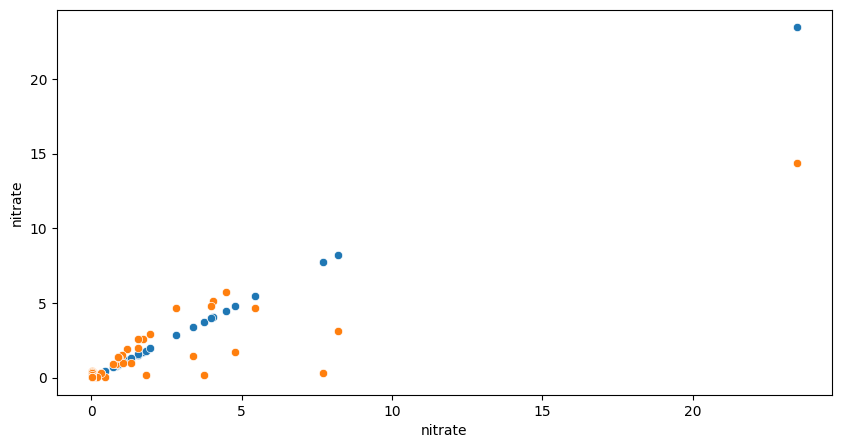

In [79]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

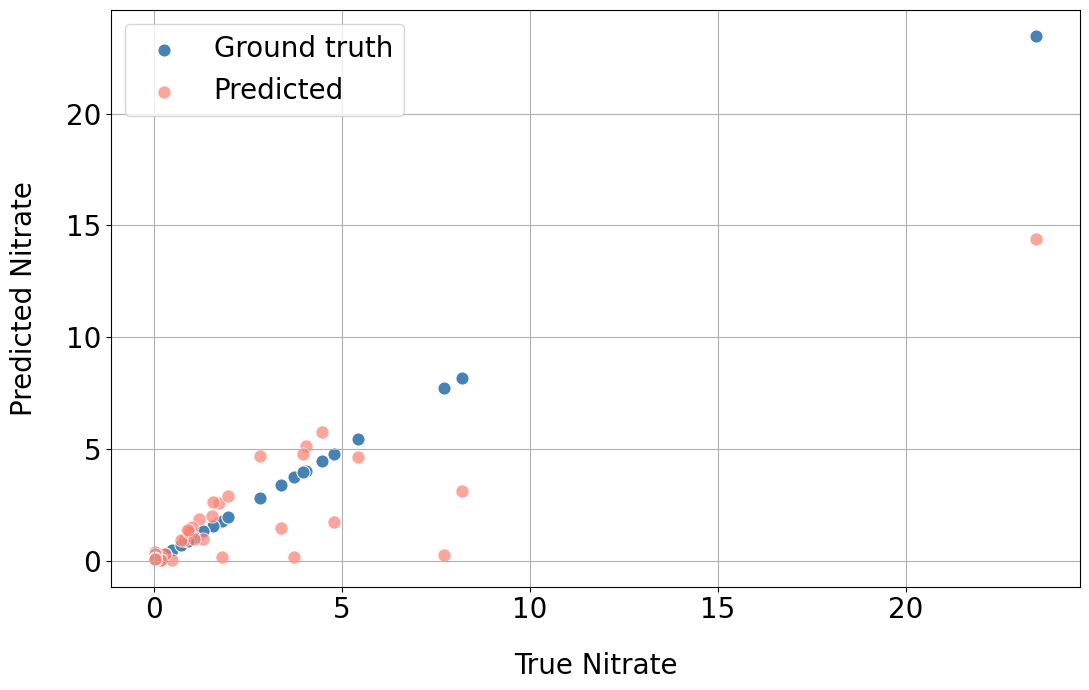

In [92]:
fig, ax = plt.subplots(figsize=(11, 7))

# Ground truth (diagonal reference line)
sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")

# Model predictions
sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

# Labels and style
ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()

## Residuals

(-2.3901881168185137, 12.0)

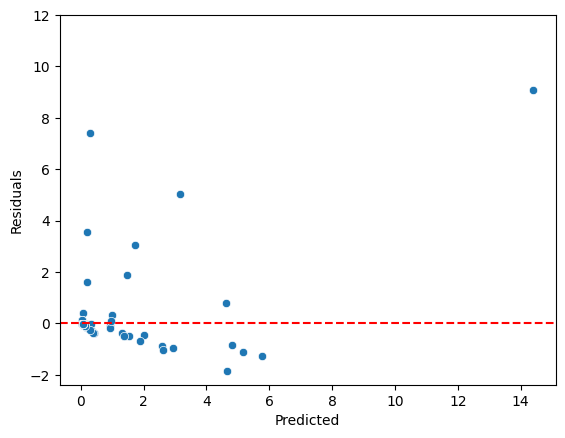

In [80]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.ylim(top=12)

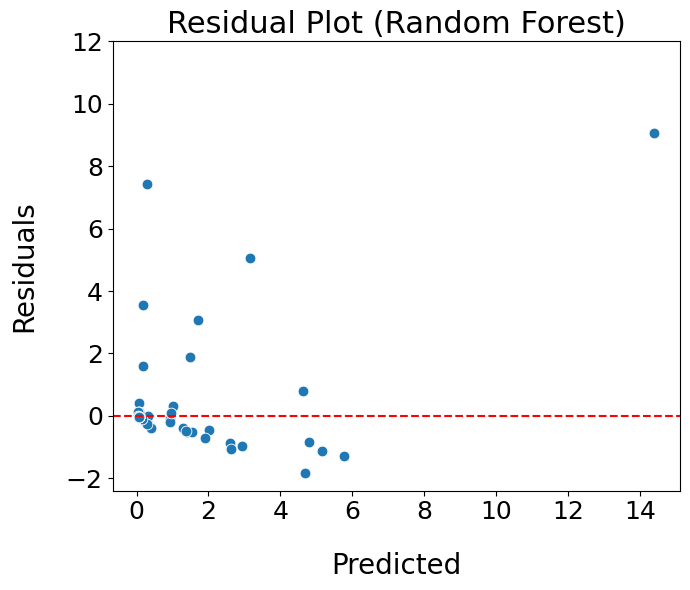

In [81]:
preds = best_model.predict(X_test)

residuals = y_test - preds
plt.figure(figsize=(7, 6))

sns.scatterplot(x=preds, y=residuals, s=60)

plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted", fontsize=20, labelpad=20)
plt.ylabel("Residuals", fontsize=20, labelpad=20)
plt.title("Residual Plot (Random Forest)", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(top=12)
plt.tight_layout()
plt.show()

In [82]:
residuals.to_csv("rf_residuals.csv")

## Predictions on the map

In [83]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

177
177
177
177


In [84]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

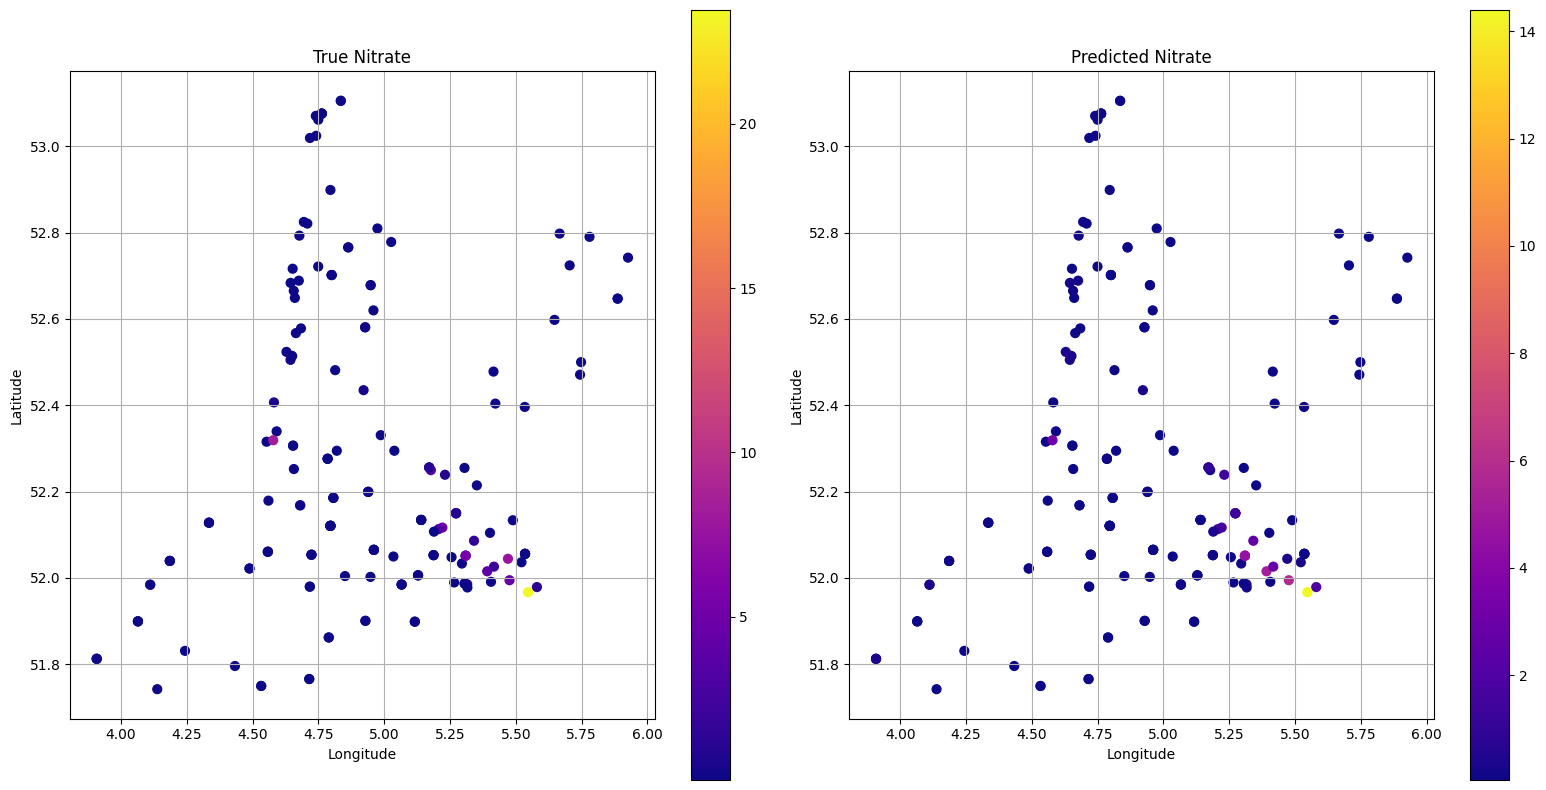

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

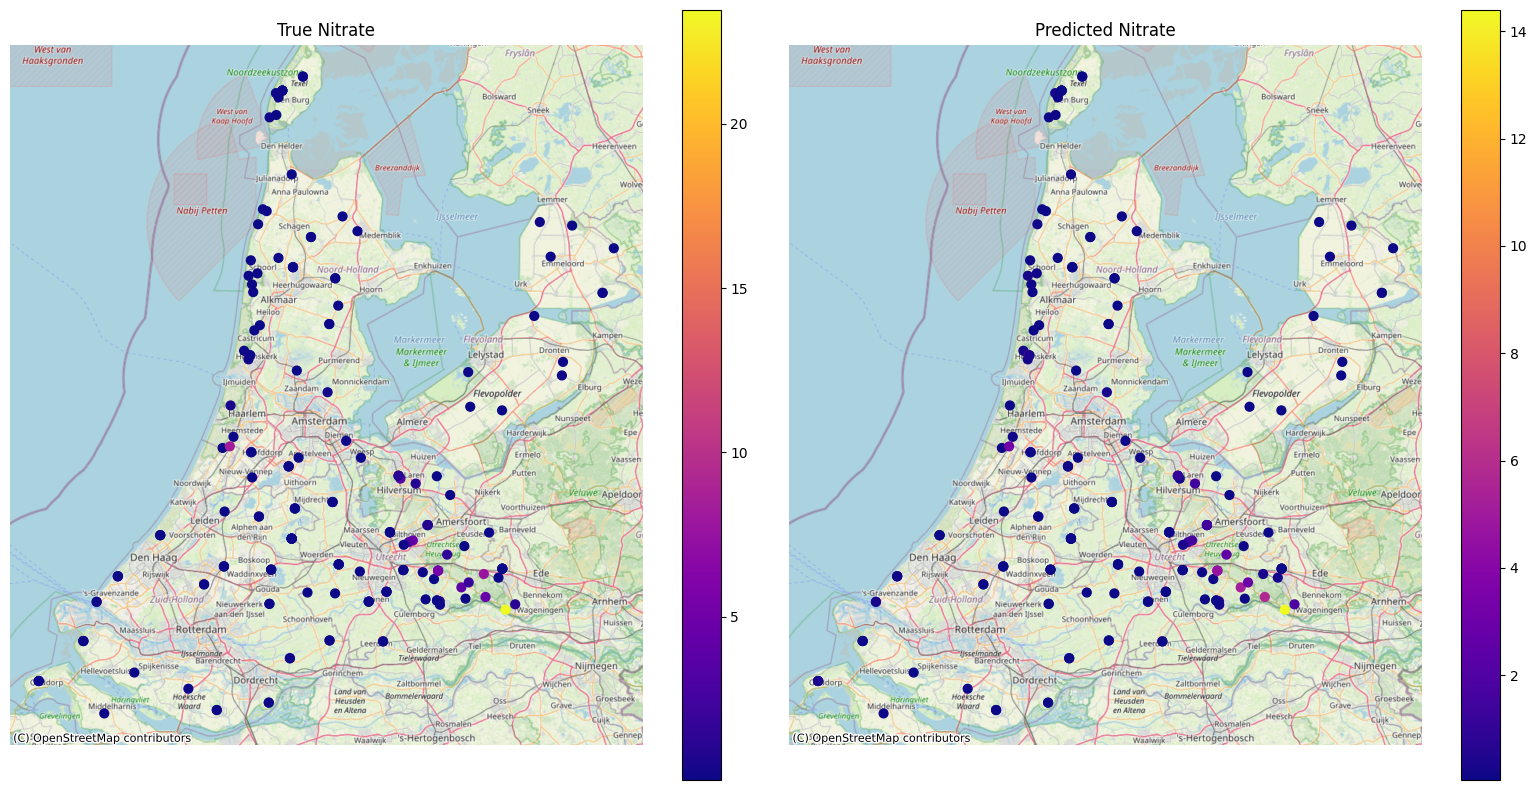

In [86]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [87]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=42))]))

In [88]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [89]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature    importance
44                              num_scaler__elevation  2.467729e-01
50                              num_scaler__acidity_1  2.415969e-01
43                      num_scaler__groundwater depth  1.109810e-01
47                           num_scaler__n deposition  8.140314e-02
33  cat_ohe__mainsoilclassification_1_Dikke eerdgr...  7.895108e-02
42                             num_scaler__population  7.463639e-02
49                              num_scaler__density_1  3.846764e-02
48                 num_scaler__organicmattercontent_1  3.442575e-02
46                            num_scaler__temperature  2.656816e-02
45                          num_scaler__precipitation  1.496928e-02
16                         cat_ohe__landuse code_25.0  7.135374e-03
14                         cat_ohe__landuse code_22.0  7.074099e-03
36  cat_ohe__mainsoilclassification_1_Kalkloze zan...  6.650089e-03
38    cat_ohe__mainsoilclassification_1_Podzolgr

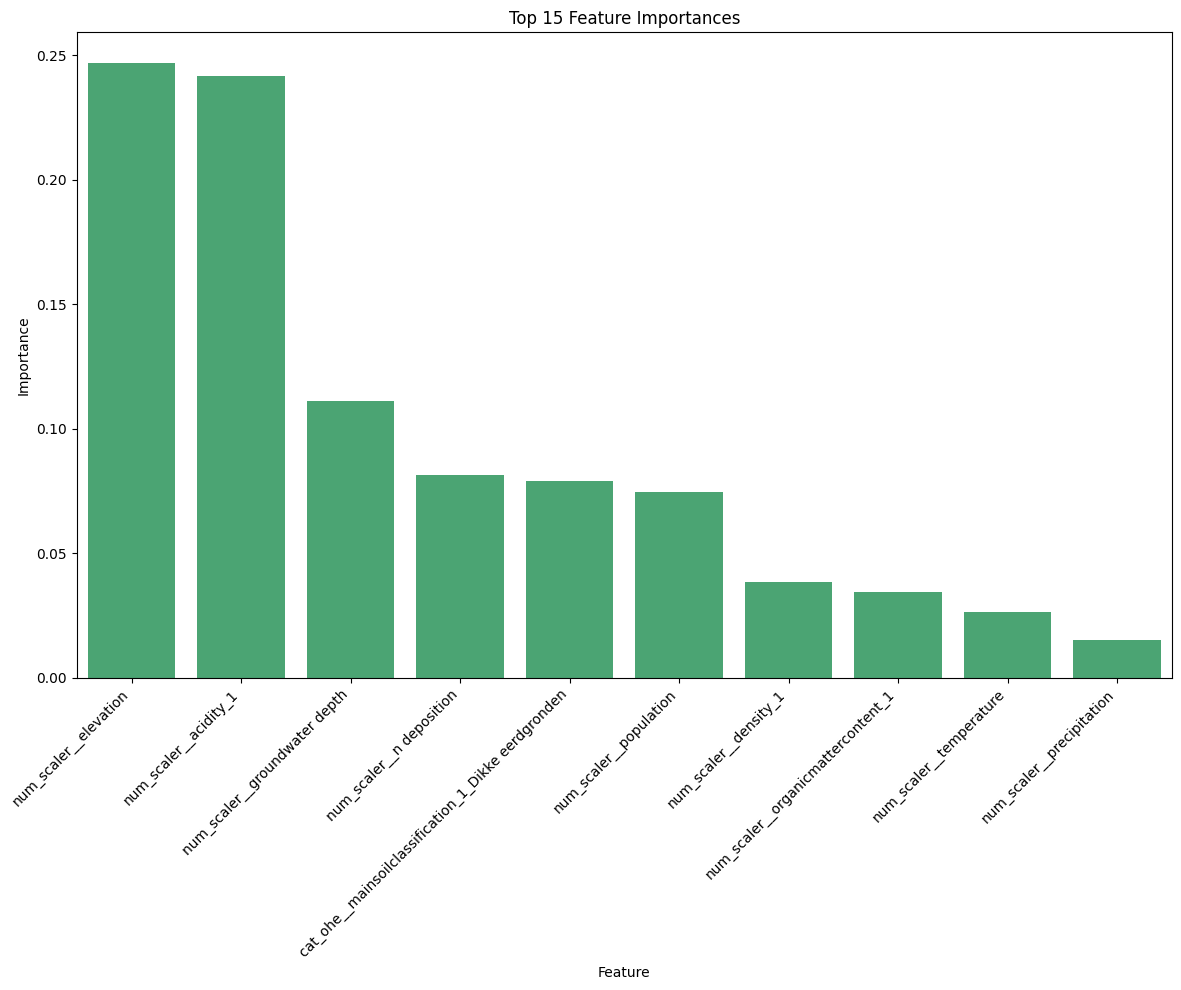

In [90]:
# Build and plot the importance DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(10), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [91]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month

# Model-Agnostic

In [96]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

  0%|          | 0/50 [00:00<?, ?it/s]

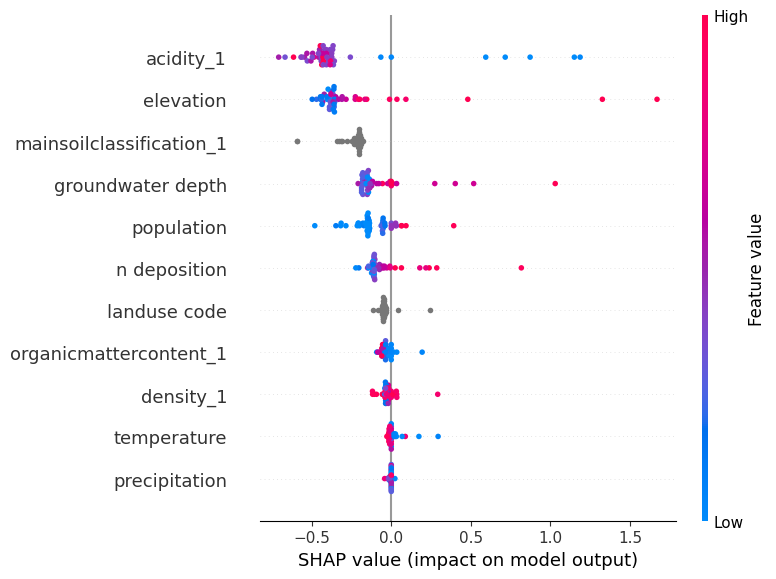

In [95]:
# Use minimal SHAP setup (no deep or tree models)
from shap.explainers import Kernel
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Safe SHAP wrapper
def shap_predict(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test.columns)
    return best_model.predict(X_df)

# Background data
X_background = X_train.sample(100, random_state=0)
explainer_shap = Kernel(shap_predict, X_background)
shap_values = explainer_shap.shap_values(X_test.iloc[:50])

# SHAP plot
import shap
shap.summary_plot(shap_values, X_test.iloc[:50])

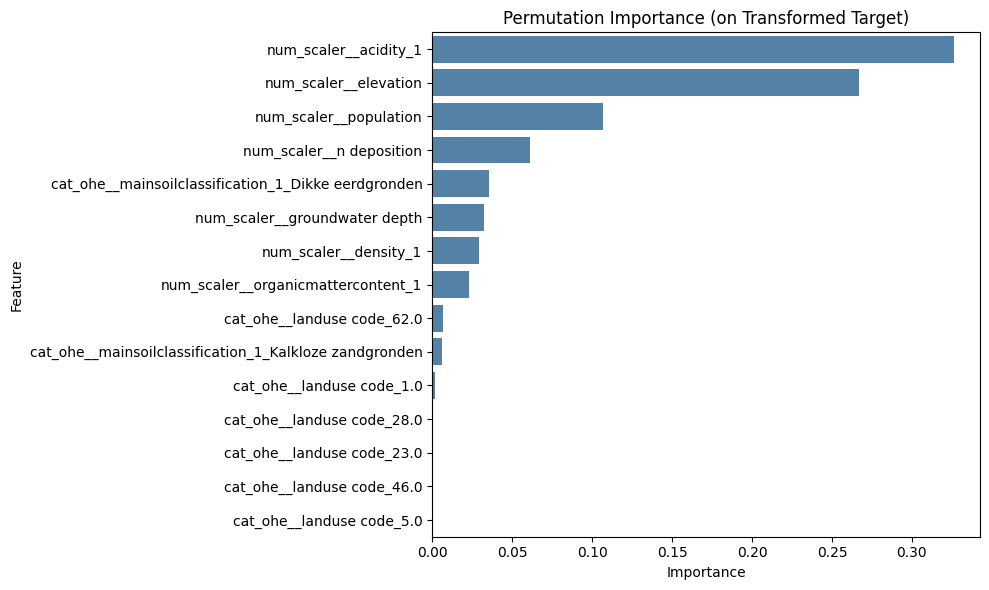

In [97]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"
